<a href="https://colab.research.google.com/github/Duygubirol/Humor-Detection---NLP/blob/main/Humor_non_humor_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 23.3 MB/s eta 0:00:00


In [4]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score 
from sklearn.base import TransformerMixin 
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

In [3]:
from google.colab import drive
drive.mount("/content/drive") 

Mounted at /content/drive


In [5]:
df= pd.read_csv("/content/drive/Othercomputers/My Laptop/Documents/dataset.csv")

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
df=df[:20000]
df.shape

(20000, 2)

In [29]:
# Replace classes 
df['humor'] = np.where((df['humor'] == 'False'), 0, df['humor'])
df['humor'] = np.where((df['humor'] == 'True'), 1, df['humor'])
# show head 
df.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",0
1,Watch: darvish gave hitter whiplash with slow ...,0
2,What do you call a turtle without its shell? d...,1
3,5 reasons the 2016 election feels so personal,0
4,"Pasco police shot mexican migrant from behind,...",0


In [30]:
X=list(df['text'])
y=list(df['humor'])

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 123)

In [32]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [33]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [34]:
#convert it in to dataset object for tensorflow
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

In [35]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    eval_steps = 10
    )

In [36]:
with training_args.strategy.scope():
    model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = TFTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset            # evaluation dataset
)

trainer.train()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_437', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

In [37]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.021011260986328124}

In [38]:
output = trainer.predict(test_dataset)[0]
output = np.argmax(output, axis = - 1)
output.shape

(4000,)

In [39]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,output)
cm

array([[2016,    7],
       [  16, 1961]])

In [40]:
# model's performance
print(classification_report(y_test, output))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2023
           1       1.00      0.99      0.99      1977

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



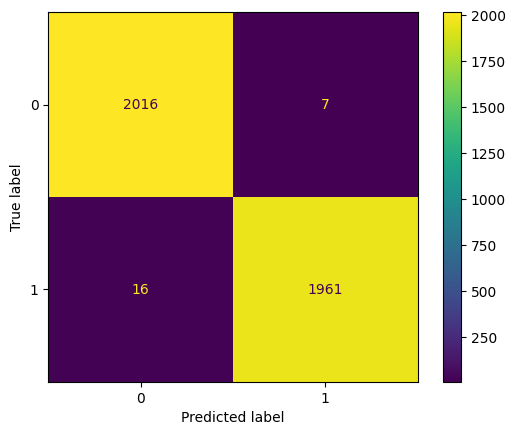

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=[0, 1])
disp.plot()

In [19]:
## another approach

text     0
humor    0
dtype: int64
True     0.50255
False    0.49745
Name: humor, dtype: float64


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_57']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/3
  40/1000 [>.............................] - ETA: 2:50 - loss: 0.3964 - accuracy: 0.8391

KeyboardInterrupt: ignored

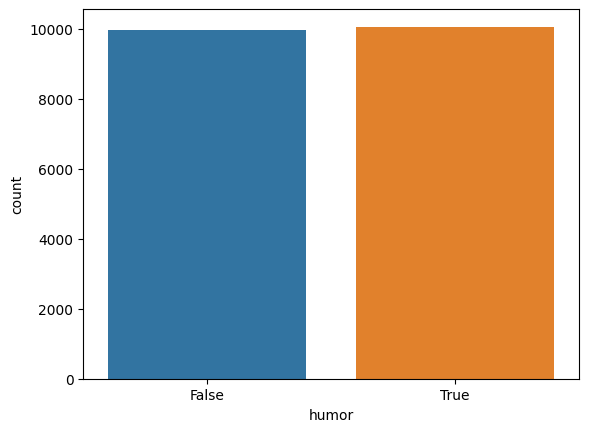

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data= pd.read_csv("/content/drive/Othercomputers/My Laptop/Documents/dataset.csv")
data=data[:20000]


# Perform exploratory data analysis (EDA)
# Check for missing values
missing_values = data.isnull().sum()
print(missing_values)

# Check the distribution of the labels
label_distribution = data['humor'].value_counts(normalize=True)
print(label_distribution)

# Visualize the label distribution
sns.countplot(x='humor', data=data)


# Clean the text data
import re
import string

def clean_text(text):
    # Remove HTML tags and URLs
    text = re.sub('<.*?>', '', text)
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation and numbers
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub('\d+', '', text)
    # Remove extra spaces and lowercase the text
    text = ' '.join(text.split()).lower()
    return text

data['text'] = data['text'].apply(clean_text)

# Perform data preprocessing
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from transformers import AutoTokenizer, DistilBertModel
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Split the dataset into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(data['text'], data['humor'], test_size=0.2, random_state=42)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize the input data
train_encodings = tokenizer(list(train_data), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_data), truncation=True, padding=True, max_length=128)

# Convert the data into TensorFlow datasets
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels.values
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels.values
))

# Create the BERT model
from transformers import TFBertForSequenceClassification

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

# Train the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model.fit(train_dataset.batch(16), epochs=3, validation_data=test_dataset.batch(16))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset.batch(16))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Make predictions on the test set
y_pred = np.argmax(model.predict(test_dataset.batch(16)).logits, axis=-1)
y_true = np.array(test_labels)
print(classification_report(y_true, y_pred))


In [22]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       False       0.96      0.96      0.96     10095
        True       0.96      0.96      0.96      9905

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000



In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [26]:
confusion_matrix(y_true, y_pred)

array([[9652,  443],
       [ 430, 9475]])

In [25]:
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=[0, 1])
disp.plot()

NameError: ignored

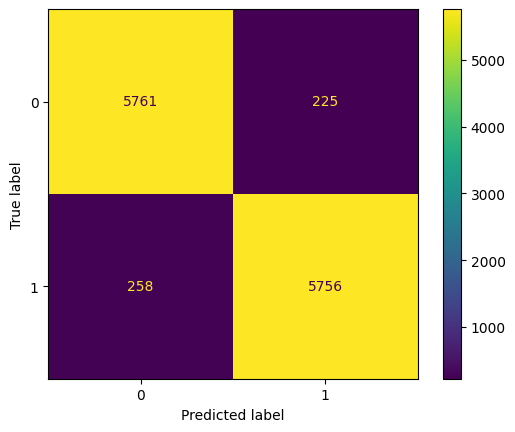

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=[0, 1])
disp.plot()

text     0
humor    0
dtype: int64
False    0.500215
True     0.499785
Name: humor, dtype: float64


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_137', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Epoch 1/3
5000/5000 [==============================] - 469s 90ms/step - loss: 0.1334 - accuracy: 0.9507 - val_loss: 0.0974 - val_accuracy: 0.9631
Epoch 2/3
5000/5000 [==============================] - 442s 88ms/step - loss: 0.0536 - accuracy: 0.9807 - val_loss: 0.1334 - val_accuracy: 0.9649
Epoch 3/3
1250/1250 [==============================] - 37s 30ms/step - loss: 0.1441 - accuracy: 0.9595
Test Loss: 0.14405308663845062
Test Accuracy: 0.9595000147819519
1250/1250 [==============================] - 38s 29ms/step
              precision    recall  f1-score   support

       False       0.97      0.95      0.96     10095
        True       0.95      0.97      0.96      9905

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000



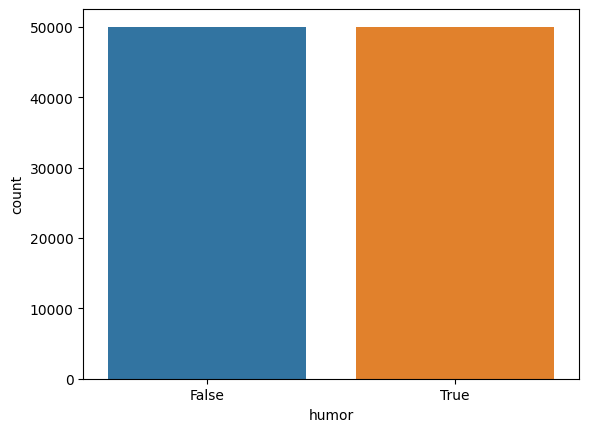

In [17]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, DistilBertModel, TFDistilBertForSequenceClassification
import tensorflow as tf
from sklearn.metrics import classification_report

# Load the dataset
data = pd.read_csv('/content/drive/Othercomputers/My Laptop/Documents/dataset.csv', nrows=200000)

# Perform exploratory data analysis (EDA)
# Check for missing values
missing_values = data.isnull().sum()
print(missing_values)

# Check the distribution of the labels
label_distribution = data['humor'].value_counts(normalize=True)
print(label_distribution)

# Visualize the label distribution
sns.countplot(x='humor', data=data)

# Clean the text data
def clean_text(text):
    # Remove HTML tags, URLs, punctuation, and numbers
    text = re.sub('<.*?>|http\S+|\d+|[^\w\s]', '', text)
    # Remove extra spaces and lowercase the text
    text = ' '.join(text.split()).lower()
    return text

data['text'] = data['text'].apply(clean_text)

# Split the dataset into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(data['text'], data['humor'], test_size=0.2, random_state=42)

# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

# Tokenize the input data
train_encodings = tokenizer(train_data.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_data.tolist(), truncation=True, padding=True, max_length=128)

# Convert the data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels.values))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels.values))

# Create the BERT model and train it
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model.fit(train_dataset.batch(16), epochs=3, validation_data=test_dataset.batch(16))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset.batch(16))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Make predictions on the test set
y_pred = np.argmax(model.predict(test_dataset.batch(16)).logits, axis=-1)
y_true = np.array(test_labels)
print(classification_report(y_true, y_pred))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import re
import string
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

# Load the dataset
data = pd.read_csv("/content/drive/Othercomputers/My Laptop/Documents/dataset.csv")

# Check for missing values
missing_values = data.isnull().sum()
print(missing_values)

# Check the distribution of the labels
label_distribution = data['humor'].value_counts(normalize=True)
print(label_distribution)

# Visualize the label distribution
#sns.countplot(x='humor', data=data)

# Clean the text data
def clean_text(text):
    # Remove HTML tags and URLs
    text = re.sub('<.*?>', '', text)
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation and numbers
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub('\d+', '', text)
    # Remove extra spaces and lowercase the text
    text = ' '.join(text.split()).lower()
    return text

data['text'] = data['text'].apply(clean_text)

# Perform data preprocessing
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(data['text'], data['humor'].replace({True: 1, False: 0}), test_size=0.2, random_state=42)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
train_encodings = tokenizer(list(train_data), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_data), truncation=True, padding=True, max_length=128)
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels.values))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels.values))

# Create the BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

# Train the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model.fit(train_dataset.batch(16), epochs=2, validation_data=test_dataset.batch(16))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset.batch(16))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Make predictions on the test set
y_pred = np.argmax(model.predict(test_dataset.batch(16)).logits, axis=-1)
y_true = np.array(test_labels)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=[0, 1])
disp.plot()


text     0
humor    0
dtype: int64
True     0.502245
False    0.497755
Name: humor, dtype: float64


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
1849/1849 [==============================] - 359s 169ms/step - loss: 0.1565 - accuracy: 0.9420 - val_loss: 0.1106 - val_accuracy: 0.9613
Epoch 2/4
1849/1849 [==============================] - 305s 165ms/step - loss: 0.0581 - accuracy: 0.9803 - val_loss: 0.1332 - val_accuracy: 0.9600
Epoch 3/4
 333/1849 [====>.........................] - ETA: 3:52 - loss: 0.0403 - accuracy: 0.9852

KeyboardInterrupt: ignored

In [20]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertTokenizer, TFTrainingArguments
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import re
import string
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

# Load the dataset
data = pd.read_csv("/content/drive/Othercomputers/My Laptop/Documents/dataset.csv")

# Check for missing values
missing_values = data.isnull().sum()
print(missing_values)

# Check the distribution of the labels
label_distribution = data['humor'].value_counts(normalize=True)
print(label_distribution)

# Visualize the label distribution
#sns.countplot(x='humor', data=data)

# Clean the text data
def clean_text(text):
    # Remove HTML tags and URLs
    text = re.sub('<.*?>', '', text)
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation and numbers
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub('\d+', '', text)
    # Remove extra spaces and lowercase the text
    text = ' '.join(text.split()).lower()
    return text

data['text'] = data['text'].apply(clean_text)



# Perform data preprocessing
from sklearn.model_selection import train_test_split


# Perform data preprocessing
from sklearn.model_selection import train_test_split
train_data, val_data, train_labels, val_labels = train_test_split(data['text'], data['humor'], test_size=0.2, random_state=42)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
train_encodings = tokenizer(list(train_data), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_data), truncation=True, padding=True, max_length=128)


# Convert the data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels))

# Define the training arguments
training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=50,
    learning_rate=2e-5,
    lr_scheduler_type='cosine',
    load_best_model_at_end=True
)

# Define the model and compile it
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
optimizer = tf.keras.optimizers.Adam(learning_rate=training_args.learning_rate)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])


# Train the model
history = model.fit(train_dataset.batch(training_args.per_device_train_batch_size),
                    validation_data=val_dataset.batch(training_args.per_device_eval_batch_size),
                    epochs=training_args.num_train_epochs,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
                    verbose=2,
                    batch_size=training_args.per_device_train_batch_size,
                    shuffle=True,
                    use_multiprocessing=True,
                    workers=-1,
                    max_queue_size=16)

text     0
humor    0
dtype: int64
False    0.5
True     0.5
Name: humor, dtype: float64


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2


AttributeError: ignored

In [17]:
train_dataset

<_TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(58,), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(58,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(58,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.bool, name=None))>

In [18]:
val_dataset

<_TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(47,), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(47,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(47,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.bool, name=None))>